# TriMeshes



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import imread
from quagmire import tools as meshtools
%matplotlib inline

## TriMesh



In [2]:
from quagmire import FlatMesh 
from quagmire import TopoMesh # all routines we need are within this class
from quagmire import SurfaceProcessMesh

minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,

x1, y1, bmask1 = meshtools.poisson_elliptical_mesh(minX, maxX, minY, maxY, 0.1, 500, r_grid=None)



In [3]:
DM = meshtools.create_DMPlex_from_points(x1, y1, bmask1, refinement_steps=2)
mesh = SurfaceProcessMesh(DM)  ## cloud array etc can surely be done better ... 


 - Delaunay triangulation 0.121737s
 - Calculate node weights and area 0.00243s
 - Find boundaries 0.001036s
 - Array sort 0.584051s
 - Construct neighbour cloud array 2.241531s
 - Construct rbf weights 0.855261s


In [4]:
x = mesh.coords[:,0]
y = mesh.coords[:,1]
bmask = mesh.bmask

radius  = np.sqrt((x**2 + y**2))
theta   = np.arctan2(y,x)

height  = np.exp(-0.025*(x**2 + y**2)**2) + 0.25 * (0.2*radius)**4  * np.cos(10.0*theta)**2 ## Less so
height  += 0.5 * (1.0-0.2*radius)

rainfall = np.ones_like(height)
rainfall[np.where( radius > 5.0)] = 0.0 

mesh.downhill_neighbours = 2
mesh.update_height(height)


 - Build downhill matrices 0.161091s


In [5]:
mo1 = mesh.identify_outflow_points()
i = np.argsort(theta[mo1])
outflows = mo1[i]

In [6]:
mesh.downhill_neighbours = 2
mesh.update_height(height)

flowpaths = mesh.cumulative_flow(rainfall*mesh.area)
logpaths = np.log10(flowpaths)
sqrtpaths = np.sqrt(flowpaths)

mesh.downhill_neighbours = 3
mesh.update_height(height)


flowpaths3 = mesh.cumulative_flow(rainfall*mesh.area)
logpaths3 = np.log10(flowpaths3)
sqrtpaths3 = np.sqrt(flowpaths3)

mesh.downhill_neighbours = 1
mesh.update_height(height)

flowpaths1 = mesh.cumulative_flow(rainfall*mesh.area)
logpaths1 = np.log10(flowpaths1)
sqrtpaths1 = np.sqrt(flowpaths1)


 - Build downhill matrices 0.190577s


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


 - Build downhill matrices 0.258199s


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


 - Build downhill matrices 0.11567s


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


In [7]:
## What's happening with the outflow points - how to find them ? 
"""
circum_points = np.where( np.abs(radius-4.9) <= 0.001 )[0]
circum_angle = theta[circum_points]

circum_flow_1 = flowpaths1[circum_points]
circum_flow_2 = flowpaths[circum_points]
circum_flow_3 = flowpaths3[circum_points]

circum_flow_1n = flowpaths_noise1[circum_points]
circum_flow_2n = flowpaths_noise[circum_points]
circum_flow_3n = flowpaths_noise3[circum_points]
"""
pass

In [8]:
# Choose a scale to plot all six flow results
fmax = 1.0

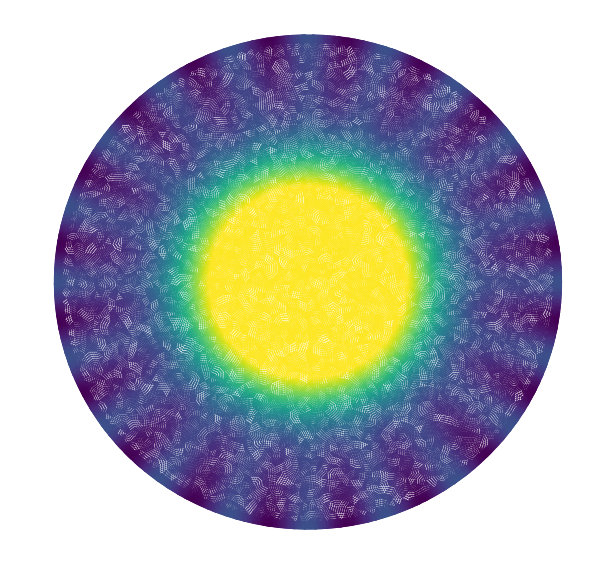

In [9]:
from scipy import ndimage

fig = plt.figure(1, figsize=(10.0, 10.0))
ax = fig.add_subplot(111)
ax.axis('off')
sc = ax.scatter(x[bmask], y[bmask], s=1, c=mesh.height[bmask], vmin=0.0, vmax=1.0)
sc = ax.scatter(x[~bmask], y[~bmask], s=5, c=mesh.height[~bmask], vmin=0.0, vmax=1.0)

# fig.colorbar(sc, ax=ax, label='height')
plt.show()

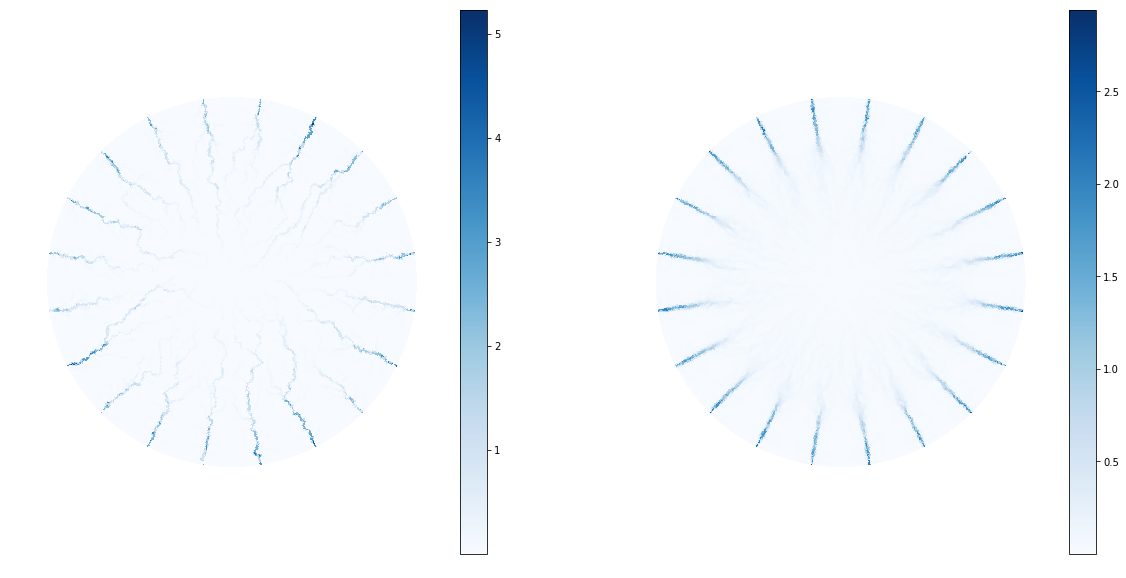

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
for ax in [ax1, ax2]:
    ax.axis('equal')
    ax.axis('off')
    
    
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, flowpaths1 ,     cmap='Blues')
im2 = ax2.tripcolor(x, y, mesh.tri.simplices, flowpaths,       cmap="Blues")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

In [12]:
print mesh.height[mesh.neighbour_cloud[0].compressed()]
print np.argmin(mesh.height[mesh.neighbour_cloud[0].compressed()])

[ 0.1420124   0.13963181  0.14876296  0.13353107  0.15254583  0.12894718
  0.12669327  0.14039329  0.15010954  0.15912931  0.13737544  0.15559602
  0.12480996  0.12684158  0.16253677  0.11796972  0.11385636  0.11630565
  0.11139082]
18


In [13]:
mesh.neighbour_cloud_distances[0]

masked_array(data = [0.0 0.02671836838155038 0.027629337182522078 0.03132622238029829
 0.033146572463681356 0.04138443326153441 0.0415300240810365
 0.0425381789643348 0.04714693973361896 0.047850436671642335
 0.053434718758260814 0.05525754340600368 0.06264776130999423
 0.06302081921906146 0.06629305014309894 0.06896137943551438
 0.07900173747708461 0.08277053620200209 0.08306313203737983 -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 --],
             mask = [False False False False False False False False False False False False
 False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  Tru

In [22]:
mesh.near_neighbours_mask.shape

(85331, 100)

In [31]:
hnear = np.ma.array(mesh.height[mesh.neighbour_cloud], mask=mesh.near_neighbours_mask)
low_neighbours = np.argmin(hnear, axis=1)

hnear = np.ma.array(mesh.height[mesh.neighbour_cloud], mask=mesh.extended_neighbours_mask)
low_eneighbours = np.argmin(hnear, axis=1)


np.where(low_eneighbours == 0)

(array([  131,   241,   654,   680,   926,  1894,  4178,  4487, 22900,
        26088, 29227, 31638, 33054, 37017, 44332, 44908, 49838, 51984,
        52704, 53619]),)

In [16]:
print mesh.height[mesh.down_neighbour[1][node]] - mesh.height[node], mesh.near_neighbours[node]

-0.0142528440906 7


In [17]:
deltah = np.ma.array(mesh.height[mesh.neighbour_cloud] - mesh.height.reshape(-1,1), mask = mesh.neighbour_cloud.mask)

In [18]:
ind = np.indices(mesh.neighbour_cloud.shape)[1]
mask = ind > mesh.near_neighbours.reshape(-1,1)

In [32]:
mesh.gaussian_dist_w.shape

(85331, 100)

In [37]:
near_neighbours = np.ma.array(mesh.neighbour_cloud, mask=mesh.near_neighbours_mask)
print near_neighbours[0]

[0 21593 21577 21581 21572 21589 21585 -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- --]


AttributeError: 'SurfaceProcessMeshClass' object has no attribute 'edges'

In [52]:
%%timeit
for i in range(0, mesh.npoints):
    np.unique(near_neighbours[near_neighbours[i].compressed()].compressed())

1 loop, best of 3: 6.04 s per loop


In [49]:
np.sort(mesh.neighbour_cloud[0].compressed())

array([    0,  5513,  5515,  5517,  5519,  5521,  5523, 21572, 21577,
       21581, 21585, 21589, 21593, 53692, 53695, 53698, 53701, 53704, 53707])

In [54]:
import petsc4py

In [77]:
xx = np.linspace(minX, maxX, 250)
yy = np.linspace(minY, maxY, 150)
x1, y1 = np.meshgrid(xx,yy)

x1 += np.random.random(x1.shape) * 0.05 * (maxX-minX) / 250.0
y1 += np.random.random(y1.shape) * 0.05 * (maxY-minY) / 150.0

x1 = x1.flatten()
y1 = y1.flatten()

pts = np.stack((x1, y1)).T


In [78]:
x1.shape

(37500,)